#SimpleABC Demo
Let's see how SimpleABC works by using it for a very easy problem. We will approximate the posterior distribution of mean and standard deviation for a Gaussian. This of course a very dumb idea, since this can be done analytically, but for demonstration purposes it will do the trick. 

In [1]:
from simple_abc import Model, basic_abc, pmc_abc
import pylab as plt
import numpy as np
from scipy import stats
%matplotlib inline
plt.style.use('ggplot')

The first thing we need to do is construct our model. To do this, we are going to make our own model object by subclassing SimpleABC's Model class. If you haven't been in the habit of using object-oriented programing, this might be intimidating, but it is not that hard. We need to provide an method to initialize the model object and replace the following methods(function):

* draw_theta
* generate_data
* summary_stats
* distance_function 


In [86]:
class MyModel(Model):
    
    #This method initializes the model object. In this case it does nothing, but you can have you model 
    #do something when the model object is created, like read in a table of something. 
    def __init__(self):
        pass
    
    #This is the method that draws from you prior. In this example it draws from frozen scipy.stats 
    #distributions that are set with the Model.set_priors method.
    def draw_theta(self):
        theta = []
        for p in self.prior:
            theta.append(p.rvs())
        return theta
    
    #The method that generates the synthetic data sets.
    def generate_data(self, theta):
        return stats.norm.rvs(loc=theta,scale=1,size=100)
    
    #The method that computes your summary statistics, for a Gaussian we just need mu and sigma
    def summary_stats(self, data):
        mu = np.mean(data)
        
        return (mu)
    
    #And finally the distance function. We are just going to use the euclidean distance 
    #from our observed summary stats
    def distance_function(self, data, synth_data):
        return np.abs(data - synth_data)


See, not so bad at all. Ok now that we have our model class, we are ready to go. Let's set up our instance of the model object.

In [92]:
#Set a random seed 
np.random.seed(914)

#We need some real values so we know it is working. 
theta_0 = 0

#Initialize our model object
model = MyModel()

#Make our "observed" data. Let's use the model's generate_data method.
data = model.generate_data(theta_0)

#Now we need to set the prior distributions. We were clever and set up our draw theta method to call 
#frozen scipy.stats objects, so we jest need to give the model our prior distributions 
model.set_prior([stats.norm(loc=0,scale=1)])

#And while we are at it, we will give the model our observed data as well
model.set_data(data)




Now we are ready to do some ABC. Let's get at least 100 samples from our approximate posterior, and set our tolerance (epsilon) to 0.15.  

In [93]:
posterior = basic_abc(model, data, min_samples=1000, epsilon=1)

Ok, let's see what we get. 

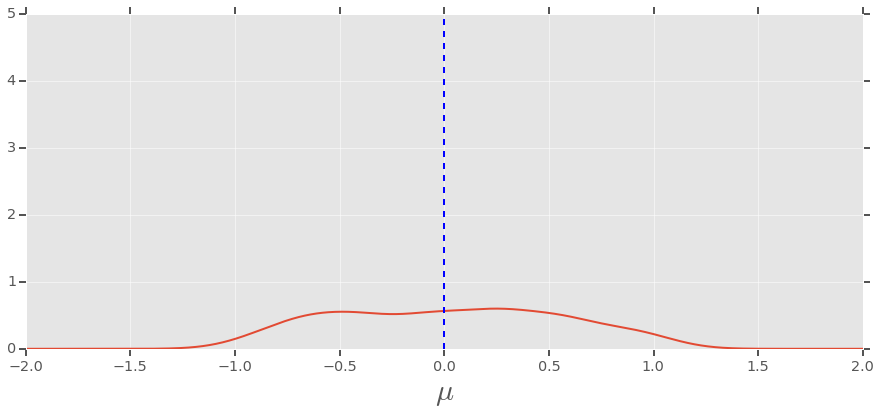

In [94]:
mu = posterior[0][0]

mukde = stats.gaussian_kde(mu)

plt.figure(figsize=(15,6))
plt.subplots_adjust(wspace=0.2)
plt.subplot(111)
#plt.hist(mu,normed=True)
x = np.linspace(-2,2,1000)
plt.plot(x, mukde(x))
plt.axvline(theta_0, ls="--")
plt.xlabel(r"$\mu$", fontsize=30)
plt.ylim(0,5)
plt.xlim(-2,2)



That's pretty good, but we can do better. If we make epsilon smaller, we will get a better approximation. We will use a method call population Monte Carlo (PMC) to get to a smaller tolerance and to sample from the prior more efficiently. 

We'll start with what we did above, but we will take 15 PMC steps.  

In [95]:
pmc_posterior = pmc_abc(model, data, epsilon_0=1, min_samples=1000, steps=15)

Starting step 0
Starting step 1
Starting step 2
Starting step 3
Starting step 4
Starting step 5
Starting step 6
Starting step 7
Starting step 8
Starting step 9
Starting step 10
Starting step 11
Starting step 12
Starting step 13
Starting step 14


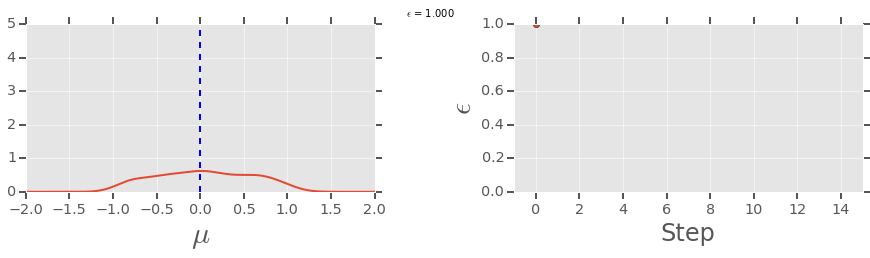

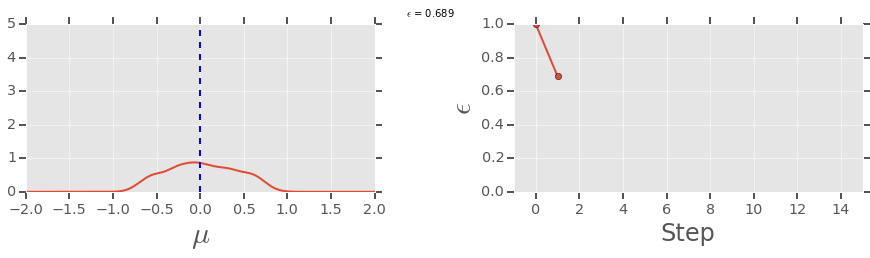

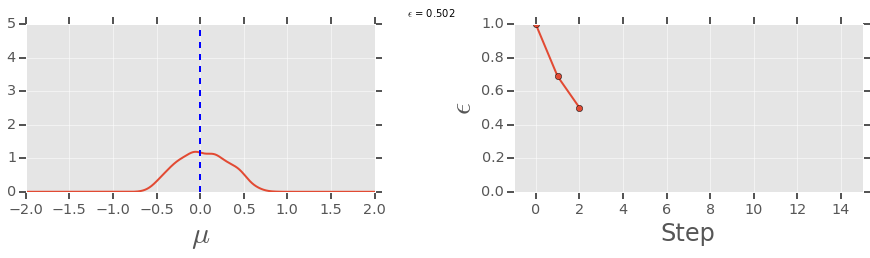

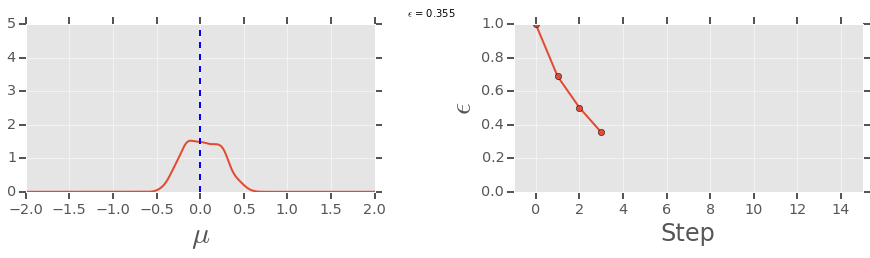

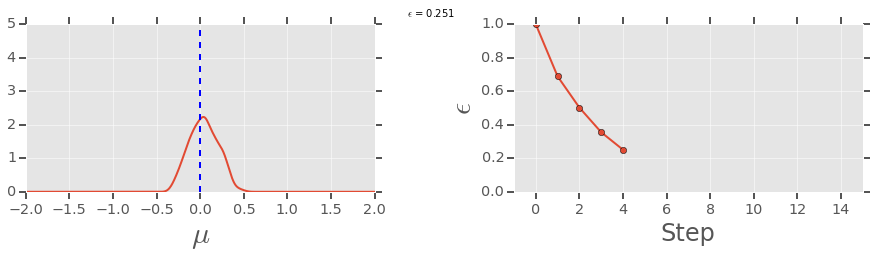

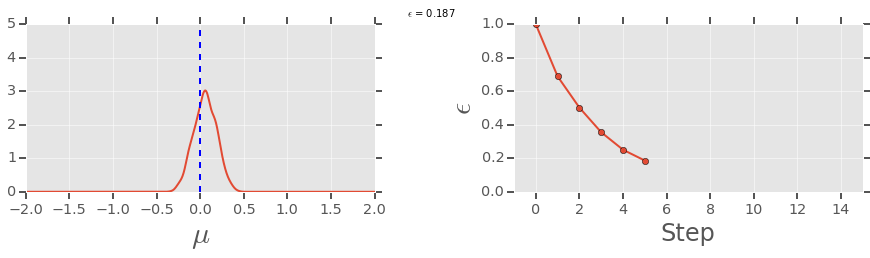

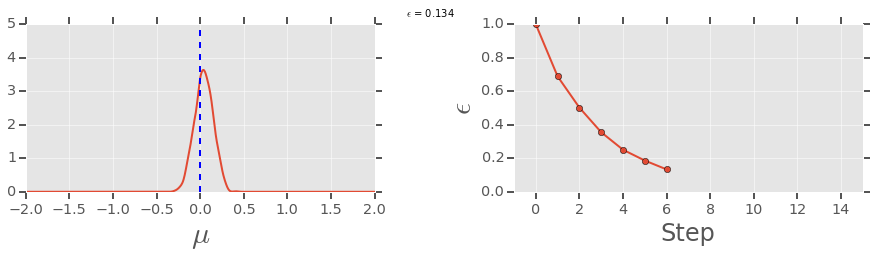

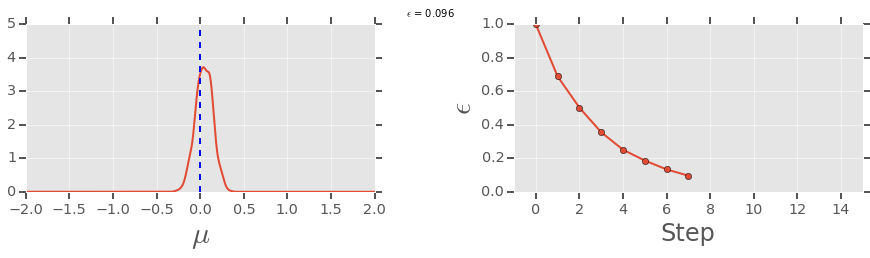

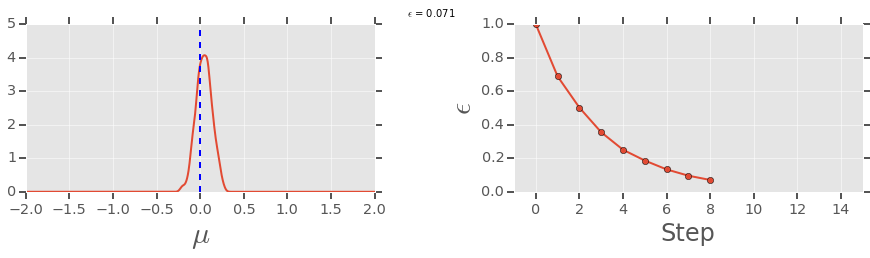

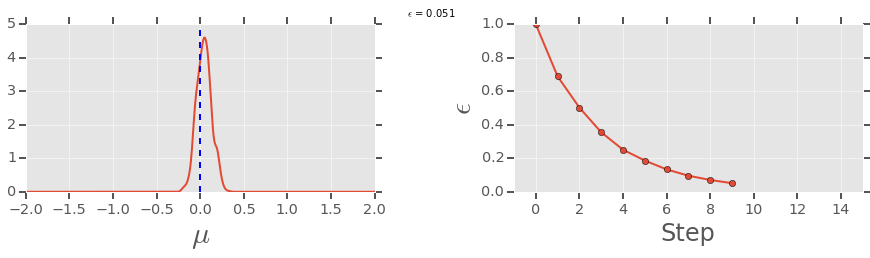

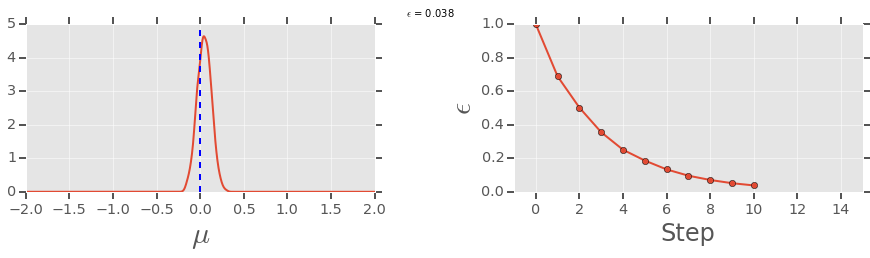

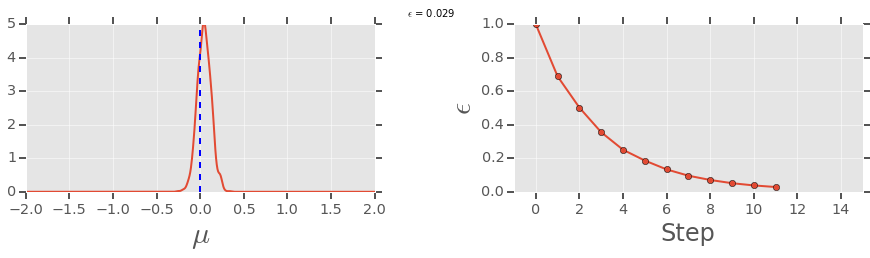

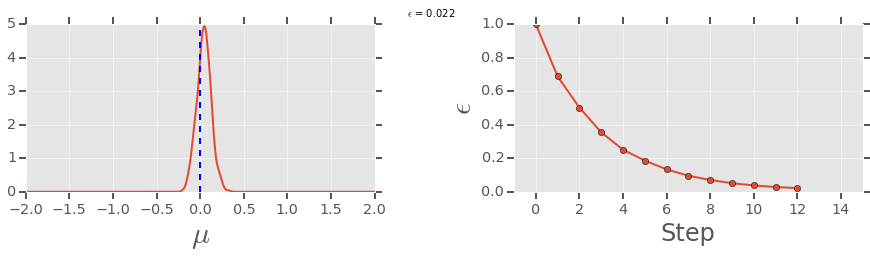

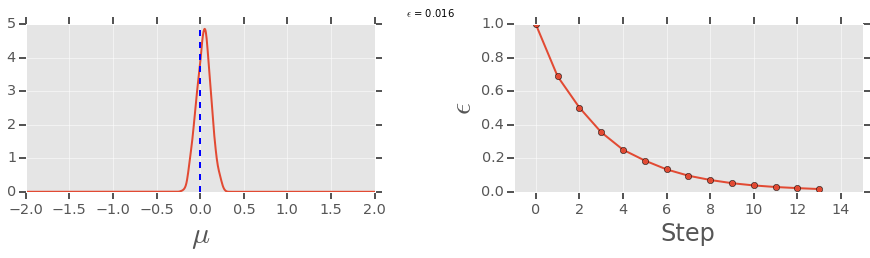

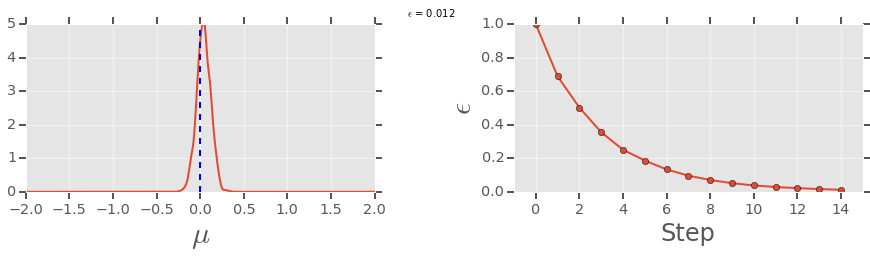

In [96]:
eps = []
for i in pmc_posterior:
    eps.append(i['epsilon'])
    mu = i[0][0]

    mukde = stats.gaussian_kde(mu)
    sigmakde = stats.gaussian_kde(sigma)
    
    plt.figure(figsize=(15,3))
    plt.subplots_adjust(wspace=0.4)
    plt.suptitle(r'$\epsilon$ = {:.3f}'.format(i['epsilon']))
    plt.subplot(121)
    x = np.linspace(-2,2,1000)
    plt.plot(x, mukde(x))
    plt.axvline(theta_0, ls='--')
    plt.ylim(0,5)
    plt.xlim(-2,2)
    plt.xlabel(r"$\mu$", fontsize=30)

    plt.subplot(122)

    plt.plot(eps,'-o')
    plt.xlabel('Step', fontsize=24)
    plt.ylabel(r'$\epsilon$', fontsize=30)
    plt.xlim(-1,15)
    plt.ylim(0,1)


As the tolerance shrinks we get and increasingly better approximation. Huzzah!